# Machine and Deep Learning for DDoS Detection
### Marcos V. O. Assis (mvoassis@gmail.com)
***

> ## Published Results:

* *A GRU deep learning system against attacks in software defined networks*

* https://doi.org/10.1016/j.jnca.2020.102942



* \***Update - 06/2022** - improved detection results through better data cleaning process. Updated results on Git. 

> ## Objectives

1. Evaluate different Machine and Deep Learning methods for anomaly detection.
2. Detection of Distributed Denial of Service Attacks

> ## Dataset

* CIC-DDoS2019 - https://www.unb.ca/cic/datasets/ddos-2019.html

> ## Evaluated Methods

* Gated Recurrent Units (GRU)
* Long-Short Term Memory (LSTM)
* Convolutional Neural Network (CNN)
* Deep Neural Network (DNN)
* Support Vector Machine (SVM)
* Logistic Regression (LR)
* Gradient Descent (GD)
* k Nearest Neighbors (kNN)

> ## Environment Config.

* Python 3.7.13
* Numpy 1.16.4
* Scikit-learn 0.21.2
* Pandas 0.24.2
* Tensorflow 1.14.0
* Keras 2.2.4
* Matplotlib 3.1.0
* Seaborn 0.11.2

***

# Importing and treating CIC-DDoS-2019

In [3]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import preprocessing
import numba as nb

## Defining functions to load files and downsample them

As this research aims to develop a binary detector (Attack or Normal), we should balance the dataset between these two classes. However, CIC-DDOS2019 has few normal flows in it. Thus, downsampling is necessary.

For the downsampling process, we allow anomalous flows to be "mult" times bigger than normal flows. This approach aims to reduce class disbalance while preventing information losses on attack flows (when the number of attack flows is downsampled to the number of normal ones, ML models could not fit appropriately).  

In [4]:
mult = 5

def load_file(path):
    data = pd.read_csv(path, sep=',')

    is_benign = data[' Label']=='BENIGN'
    flows_ok = data[is_benign]
    flows_ddos_full = data[~is_benign]
    
    sizeDownSample = len(flows_ok)*mult # tamanho do set final de dados anomalos
    
    # downsample majority
    if (len(flows_ok)*mult) < (len(flows_ddos_full)): 
        flows_ddos_reduced = resample(flows_ddos_full,
                                         replace = False, # sample without replacement
                                         n_samples = sizeDownSample, # match minority n
                                         random_state = 27) # reproducible results
    else:
        flows_ddos_reduced = flows_ddos_full
    
    return flows_ok, flows_ddos_reduced

 
def load_huge_file(path):
    df_chunk = pd.read_csv(path, chunksize=500000)
    
    chunk_list_ok = []  # append each chunk df here 
    chunk_list_ddos = [] 

    # Each chunk is in df format
    for chunk in df_chunk:  
        # perform data filtering 
        is_benign = chunk[' Label']=='BENIGN'
        flows_ok = chunk[is_benign]
        flows_ddos_full = chunk[~is_benign]
        
        if (len(flows_ok)*mult) < (len(flows_ddos_full)): 
            sizeDownSample = len(flows_ok)*mult # tamanho do set final de dados anomalos
            
            # downsample majority
            flows_ddos_reduced = resample(flows_ddos_full,
                                             replace = False, # sample without replacement
                                             n_samples = sizeDownSample, # match minority n
                                             random_state = 27) # reproducible results 
        else:
            flows_ddos_reduced = flows_ddos_full
            
        # Once the data filtering is done, append the chunk to list
        chunk_list_ok.append(flows_ok)
        chunk_list_ddos.append(flows_ddos_reduced)
        
    # concat the list into dataframe 
    flows_ok = pd.concat(chunk_list_ok)
    flows_ddos = pd.concat(chunk_list_ddos)
    
    return flows_ok, flows_ddos

In [5]:

''' Commands for Windows
!curl -o temp.zip http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-01-12.zip
!tar -xf CSV-01-12.zip
!tar -xf CSV-03-11.zip
!del CSV-01-12.zip
!del CSV-03-11.zip'''
''' Commands for Linux
!wget "http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-01-12.zip" -O temp.zip
! unzip temp.zip
! rm temp.zip
'''

' Commands for Linux\n!wget "http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-01-12.zip" -O temp.zip\n! unzip temp.zip\n! rm temp.zip\n'

In [6]:
'''df = pd.read_csv("./01-12/TFTP.csv", nrows= 100000) # very large file, 
# if read completely will crash  colab, so only reading first 100000 rows
df = df.iloc[:40000]
df.to_csv("tftp.csv")

df = pd.read_csv("./01-12/DrDoS_LDAP.csv")
df = df.iloc[:40000]
df.to_csv("ldap.csv")

df = pd.read_csv("./01-12/DrDoS_MSSQL.csv")
df = df.iloc[:40000]
df.to_csv("mssql.csv")

df = pd.read_csv("./01-12/DrDoS_NetBIOS.csv")
df = df.iloc[:40000]
df.to_csv("netBIOS.csv")

df = pd.read_csv("./01-12/DrDoS_NTP.csv")
df = df.iloc[:40000]
df.to_csv("ntp.csv")

df = pd.read_csv("./01-12/DrDoS_SNMP.csv")
df = df.iloc[:40000]
df.to_csv("snmp.csv")

df = pd.read_csv("./01-12/DrDoS_SSDP.csv")
df = df.iloc[:40000]
df.to_csv("ssdp.csv")

df = pd.read_csv("./01-12/DrDoS_UDP.csv")
df = df.iloc[:40000]
df.to_csv("udp.csv")

df = pd.read_csv("./01-12/Syn.csv")
df = df.iloc[:40000]
df.to_csv("syn.csv")

df = pd.read_csv("./01-12/DrDoS_DNS.csv")
df = df.iloc[:40000]
df.to_csv("dns.csv")

df = pd.read_csv("./01-12/UDPLag.csv")
df = df.iloc[:40000]
df.to_csv("udplag.csv")'''

'df = pd.read_csv("./01-12/TFTP.csv", nrows= 100000) # very large file, \n# if read completely will crash  colab, so only reading first 100000 rows\ndf = df.iloc[:40000]\ndf.to_csv("tftp.csv")\n\ndf = pd.read_csv("./01-12/DrDoS_LDAP.csv")\ndf = df.iloc[:40000]\ndf.to_csv("ldap.csv")\n\ndf = pd.read_csv("./01-12/DrDoS_MSSQL.csv")\ndf = df.iloc[:40000]\ndf.to_csv("mssql.csv")\n\ndf = pd.read_csv("./01-12/DrDoS_NetBIOS.csv")\ndf = df.iloc[:40000]\ndf.to_csv("netBIOS.csv")\n\ndf = pd.read_csv("./01-12/DrDoS_NTP.csv")\ndf = df.iloc[:40000]\ndf.to_csv("ntp.csv")\n\ndf = pd.read_csv("./01-12/DrDoS_SNMP.csv")\ndf = df.iloc[:40000]\ndf.to_csv("snmp.csv")\n\ndf = pd.read_csv("./01-12/DrDoS_SSDP.csv")\ndf = df.iloc[:40000]\ndf.to_csv("ssdp.csv")\n\ndf = pd.read_csv("./01-12/DrDoS_UDP.csv")\ndf = df.iloc[:40000]\ndf.to_csv("udp.csv")\n\ndf = pd.read_csv("./01-12/Syn.csv")\ndf = df.iloc[:40000]\ndf.to_csv("syn.csv")\n\ndf = pd.read_csv("./01-12/DrDoS_DNS.csv")\ndf = df.iloc[:40000]\ndf.to_csv("dns.

## Loading CIC-DDoS2019 - Day 1 (training)

In [18]:
# file 1
flows_ok, flows_ddos = load_huge_file('./01-12/TFTP.csv')
print('file 1 loaded')

# file 2
a,b = load_file('./01-12/DrDoS_LDAP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 2 loaded')

# file 3
a,b = load_file('./01-12/DrDoS_MSSQL.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 3 loaded')

# file 4
a,b = load_file('./01-12/DrDoS_NetBIOS.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 4 loaded')

# file 5
a,b = load_file('./01-12/DrDoS_NTP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 5 loaded')

# file 6
a,b = load_file('./01-12/DrDoS_SNMP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 6 loaded')

# file 7
a,b = load_file('./01-12/DrDoS_SSDP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 7 loaded')

# file 8
a,b = load_file('./01-12/DrDoS_UDP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 8 loaded')

# file 9
a,b = load_file('./01-12/Syn.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 9 loaded')

# file 10
a,b = load_file('./01-12/DrDoS_DNS.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 10 loaded')

# file 11
a,b = load_file('./01-12/UDPLag.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 11 loaded')

del a,b

samples = pd.concat([flows_ok, flows_ddos], ignore_index=True)
samples.to_csv(r'./01-12/export_dataframe.csv', index = None, header=True) 

del flows_ddos, flows_ok

C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:31: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df_chunk:
C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:31: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df_chunk:
C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:31: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df_chunk:
C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:31: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df_chunk:
C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:31: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df_chunk:
C:\Users\anicc\AppData\Local\T

file 1 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 2 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 3 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 4 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 5 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 6 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 7 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 8 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 9 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 10 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 11 loaded


## Loading CIC-DDoS2019 - Day 2 (testing)

In [19]:
# file 1
flows_ok, flows_ddos = load_file('./03-11/LDAP.csv')
print('file 1 loaded')

# file 2
a,b = load_file('./03-11/MSSQL.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 2 loaded')

# file 3
a,b = load_file('./03-11/NetBIOS.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 3 loaded')

# file 4
a,b = load_file('./03-11/PortMap.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 4 loaded')

# file 5
a,b = load_file('./03-11/Syn.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 5 loaded') 

C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 1 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 2 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 3 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 4 loaded


C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3645198409.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, sep=',')


file 5 loaded


In [20]:
'''# following files won't load**
# file 6

a,b = load_file('cicddos2019/03-11/UDP.csv')
flows_ok = flows_ok.append(a,ignore_index=True)
flows_ddos = flows_ddos.append(b,ignore_index=True)
print('file 6 loaded')

# file 7
a,b = load_file('cicddos2019/03-11/UDPLag.csv')
flows_ok = flows_ok.append(a,ignore_index=True)
flows_ddos = flows_ddos.append(b,ignore_index=True)
print('file 7 loaded')'''

tests = pd.concat([flows_ok, flows_ddos], ignore_index=True)
tests.to_csv(r'./01-12/export_tests.csv', index = None, header=True) 

del flows_ddos, flows_ok, a, b

## CIC-DDoS2019 Data Processing

In [22]:
# training data
samples = pd.read_csv('./01-12/export_dataframe.csv', sep=',')

def string2numeric_hash(text):
    import hashlib
    return int(hashlib.md5(text).hexdigest()[:8], 16)

# Flows Packet/s e Bytes/s - Replace infinity by 0
samples = samples.replace('Infinity','0')
samples = samples.replace(np.inf,0)
#samples = samples.replace('nan','0')
samples[' Flow Packets/s'] = pd.to_numeric(samples[' Flow Packets/s'])

samples['Flow Bytes/s'] = samples['Flow Bytes/s'].fillna(0)
samples['Flow Bytes/s'] = pd.to_numeric(samples['Flow Bytes/s'])


#Label
samples[' Label'] = samples[' Label'].replace('BENIGN',0)
samples[' Label'] = samples[' Label'].replace('DrDoS_DNS',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_LDAP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_MSSQL',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_NTP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_NetBIOS',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_SNMP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_SSDP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_UDP',1)
samples[' Label'] = samples[' Label'].replace('Syn',1)
samples[' Label'] = samples[' Label'].replace('TFTP',1)
samples[' Label'] = samples[' Label'].replace('UDP-lag',1)
samples[' Label'] = samples[' Label'].replace('WebDDoS',1)

#Timestamp - Drop day, then convert hour, minute and seconds to hashing 
colunaTime = pd.DataFrame(samples[' Timestamp'].str.split(' ').tolist(), columns = ['dia','horas'])
colunaTime = pd.DataFrame(colunaTime['horas'].str.split('.').tolist(),columns = ['horas','milisec'])
stringHoras = pd.DataFrame(colunaTime['horas'].str.encode('utf-8'))
samples[' Timestamp'] = pd.DataFrame(stringHoras['horas'].apply(string2numeric_hash))#colunaTime['horas']
del colunaTime,stringHoras


# flowID - IP origem - IP destino - Simillar HTTP -> Drop (individual flow analysis)
del samples[' Source IP']
del samples[' Destination IP']
del samples['Flow ID']
del samples['SimillarHTTP']
del samples['Unnamed: 0']

samples.to_csv(r'./01-12/export_dataframe_proc.csv', index = None, header=True) 
print('Training data processed')

C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\1082182861.py:2: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('./01-12/export_dataframe.csv', sep=',')


Training data processed


In [23]:
# test data
tests = pd.read_csv('./01-12/export_tests.csv', sep=',')

def string2numeric_hash(text):
    import hashlib
    return int(hashlib.md5(text).hexdigest()[:8], 16)

# Flows Packet/s e Bytes/s - Change infinity by 0
tests = tests.replace('Infinity','0')
tests = tests.replace(np.inf,0)
#amostras = amostras.replace('nan','0')
tests[' Flow Packets/s'] = pd.to_numeric(tests[' Flow Packets/s'])

tests['Flow Bytes/s'] = tests['Flow Bytes/s'].fillna(0)
tests['Flow Bytes/s'] = pd.to_numeric(tests['Flow Bytes/s'])


#Label
tests[' Label'] = tests[' Label'].replace('BENIGN',0)
tests[' Label'] = tests[' Label'].replace('LDAP',1)
tests[' Label'] = tests[' Label'].replace('NetBIOS',1)
tests[' Label'] = tests[' Label'].replace('MSSQL',1)
tests[' Label'] = tests[' Label'].replace('Portmap',1)
tests[' Label'] = tests[' Label'].replace('Syn',1)
#tests[' Label'] = tests[' Label'].replace('DrDoS_SNMP',1)
#tests[' Label'] = tests[' Label'].replace('DrDoS_SSDP',1)

#Timestamp - Drop day, then convert hour, minute and seconds to hashing 
colunaTime = pd.DataFrame(tests[' Timestamp'].str.split(' ').tolist(), columns = ['dia','horas'])
colunaTime = pd.DataFrame(colunaTime['horas'].str.split('.').tolist(),columns = ['horas','milisec'])
stringHoras = pd.DataFrame(colunaTime['horas'].str.encode('utf-8'))
tests[' Timestamp'] = pd.DataFrame(stringHoras['horas'].apply(string2numeric_hash))#colunaTime['horas']
del colunaTime,stringHoras

# flowID - IP origem - IP destino - Simillar HTTP -> Deletar (analise fluxo a fluxo)
del tests[' Source IP']
del tests[' Destination IP']
del tests['Flow ID']
del tests['SimillarHTTP']
del tests['Unnamed: 0']

tests.to_csv(r'./01-12/export_tests_proc.csv', index = None, header=True) 
print('Test data processed')

C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\915912304.py:2: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  tests = pd.read_csv('./01-12/export_tests.csv', sep=',')


Test data processed


## Methods implementation

Importing required library

In [42]:
# Import required libraries
from keras.models import Sequential

from keras.layers import Dense,GRU,Embedding,Dropout,Flatten,Conv1D,MaxPooling1D,LSTM
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

### Gated Recurrent Units (GRU)

In [43]:
#input_size
# -> CIC-DDoS2019 82
# -> CIC-IDS2018 78

def GRU_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(GRU(32, input_shape=(input_size,1), return_sequences=False)) #
    model.add(Dropout(0.5))    
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.build()
    print(model.summary())
    
    return model

### Convolutional Neural Network (CNN)

In [44]:
def CNN_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(input_size,1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=32, kernel_size=16, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

### Long-Short Term Memory (LSTM)

In [45]:
def LSTM_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(LSTM(32,input_shape=(input_size,1), return_sequences=False))
    model.add(Dropout(0.5))    
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

### Deep Neural Network (DNN)

In [46]:
def DNN_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(Dense(2, activation='relu', input_shape=(input_size,)))
    #model.add(Dense(100, activation='relu'))   
    #model.add(Dense(40, activation='relu'))
    #model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

### Support Vector Machine (SVM)

In [47]:
def SVM():
    return SVC(kernel='linear')

### Logistic Regression (LR)

In [48]:
def LR():
    return LogisticRegression()

### Gradient Descent (GD)

In [49]:
def GD():
    return SGDClassifier()

### k Nearest Neighbors (kNN)

In [50]:
def kNN():
    return KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Auxiliar Functions

Implementation of auxiliar functions, such as testing, compiling/training, 3d reshape, etc. 

### train_test(samples)
> Receives a group of samples and split it in train/test sets.

In [51]:


def train_test(samples):
    # Import `train_test_split` from `sklearn.model_selection`
    from sklearn.model_selection import train_test_split
    import numpy as np
    
    # Specify the data 
    X=samples.iloc[:,0:(samples.shape[1]-1)]
    
    # Specify the target labels and flatten the array
    #y= np.ravel(amostras.type)
    y= samples.iloc[:,-1]
    
    # Split the data up in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test


### normalize_data(X_train,X_test)

> Normalize data between -1 and 1

In [52]:
def normalize_data(X_train,X_test):
    # Import `StandardScaler` from `sklearn.preprocessing`
    from sklearn.preprocessing import StandardScaler,MinMaxScaler
    
    # Define the scaler 
    #scaler = StandardScaler().fit(X_train)
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    
    # Scale the train set
    X_train = scaler.transform(X_train)
    
    # Scale the test set
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

In [ ]:
'''from multiprocessing import Pool
num_processes = 6
def normalize_data(X_train, X_test, scaler=None):
    from sklearn.preprocessing import MinMaxScaler
    
    if not scaler:
        scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    X_train_list = np.array_split(X_train, num_processes)
    X_test_list = np.array_split(X_test, num_processes)

    pool = Pool(num_processes)
    results = []

    for i in range(num_processes):
        scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train_list[i])
        result = pool.apply_async(normalize_data, args=(X_train_list[i], X_test_list[i], scaler))
        results.append(result)

    pool.close()
    pool.join()
    return X_train, X_test'''

'from multiprocessing import Pool\nnum_processes = 6\ndef normalize_data(X_train, X_test, scaler=None):\n    from sklearn.preprocessing import MinMaxScaler\n    \n    if not scaler:\n        scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)\n    \n    X_train = scaler.transform(X_train)\n    X_test = scaler.transform(X_test)\n\n    X_train_list = np.array_split(X_train, num_processes)\n    X_test_list = np.array_split(X_test, num_processes)\n\n    pool = Pool(num_processes)\n    results = []\n\n    for i in range(num_processes):\n        scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train_list[i])\n        result = pool.apply_async(normalize_data, args=(X_train_list[i], X_test_list[i], scaler))\n        results.append(result)\n\n    pool.close()\n    pool.join()\n    return X_train, X_test'

### format_{2,3}d()

> Reshape data in 3d or 2d format (for input in methods such as GRU, CNN and LSTM)

In [53]:
# Reshape data input

'''@nb.jit(nopython=True)
def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

@nb.jit(nopython=True)
def format_2d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1]))'''

def format_3d(df):
    
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

def format_2d(df):
    
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1]))

### compile_train(model,X_train,y_train,deep=True)

> Compile and train learning model

> deep = False for scikit-learn ML methods


In [54]:
# compile and train learning model

def compile_train(model,X_train,y_train,deep=True):
    
    if(deep==True):
        import matplotlib.pyplot as plt


        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        history = model.fit(X_train, y_train,epochs=10, batch_size=256, verbose=1)
        #model.fit(X_train, y_train,epochs=3)

        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()

        print(model.metrics_names)
    
    else:
        model.fit(X_train, y_train) #SVM, LR, GD
    
    print('Model Compiled and Trained')
    return model

### testes(model,X_test,y_test,y_pred, deep=True)

> Testing performance outcomes of the methods

> deep = False for scikit-learn ML methods


In [55]:
# Testing performance outcomes of the methods

def testes(model,X_test,y_test,y_pred, deep=True):
    if(deep==True): 
        score = model.evaluate(X_test, y_test,verbose=1)

        print(score)
    
    # Alguns testes adicionais
    #y_test = formatar2d(y_test)
    #y_pred = formatar2d(y_pred)
    
    
    # Import the modules from `sklearn.metrics`
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
    
    # Accuracy 
    acc = accuracy_score(y_test, y_pred)
    print('\nAccuracy')
    print(acc)
    
    # Precision 
    prec = precision_score(y_test, y_pred)#,average='macro')
    print('\nPrecision')
    print(prec)
    
    # Recall
    rec = recall_score(y_test, y_pred) #,average='macro')
    print('\nRecall')
    print(rec)
    
    # F1 score
    f1 = f1_score(y_test,y_pred) #,average='macro')
    print('\nF1 Score')
    print(f1)
    
    #average
    avrg = (acc+prec+rec+f1)/4
    print('\nAverage (acc, prec, rec, f1)')
    print(avrg)
    
    return acc, prec, rec, f1, avrg

### test_normal_atk(y_test,y_pred):

> Calculate the correct classification rate of normal and attack flow records

In [56]:
def test_normal_atk(y_test,y_pred):
    df = pd.DataFrame()
    df['y_test'] = y_test
    df['y_pred'] = y_pred
    
    normal = len(df.query('y_test == 0'))
    atk = len(y_test)-normal
    
    wrong = df.query('y_test != y_pred')
    
    normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
    atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk
    
    #print(normal_detect_rate,atk_detect_rate)
    
    return normal_detect_rate, atk_detect_rate
    

### Saving and Loading methods

> Methods for saving and loading trained models

In [57]:
# Save model and weights

def save_model(model,name):
    from keras.models import model_from_json
    
    arq_json = 'Models/' + name + '.json'
    model_json = model.to_json()
    with open(arq_json,"w") as json_file:
        json_file.write(model_json)
    
    arq_h5 = 'Models/' + name + '.h5'
    model.save_weights(arq_h5)
    print('Model Saved')
    
def load_model(name):
    from keras.models import model_from_json
    
    arq_json = 'Models/' + name + '.json'
    json_file = open(arq_json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    arq_h5 = 'Models/' + name + '.h5'
    loaded_model.load_weights(arq_h5)
    
    print('Model loaded')
    
    return loaded_model

def save_Sklearn(model,nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'wb') as file:
        pickle.dump(model,file)
    print('Model sklearn saved')

def load_Sklearn(nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'rb') as file:
        model = pickle.load(file)
    print('Model sklearn loaded')
    return model

# Main script for testing the learning methods

> **Dataset - CIC-DDoS2019**

Loading training dataset (day 1), upsampling normal flows for balancing the training set. 

In [36]:
# UPSAMPLE OF NORMAL FLOWS
    
samples = pd.read_csv('./01-12/export_dataframe_proc.csv', sep=',')

X_train, X_test, y_train, y_test = train_test(samples)


#junta novamente pra aumentar o numero de normais
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
is_benign = X[' Label']==0 #base de dados toda junta

normal = X[is_benign]
ddos = X[~is_benign]

# upsample minority
normal_upsampled = resample(normal,
                          replace=True, # sample with replacement
                          n_samples=len(ddos), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([normal_upsampled, ddos])

# Specify the data 
X_train=upsampled.iloc[:,0:(upsampled.shape[1]-1)]    #DDoS
y_train= upsampled.iloc[:,-1]  #DDoS

input_size = (X_train.shape[1], 1)

del X, normal_upsampled, ddos, upsampled, normal #, l1, l2 

Importing the test dataset (day 2) and normalizing data.

In [37]:
tests = pd.read_csv('./01-12/export_tests_proc.csv', sep=',')

# X_test = np.concatenate((X_test,(tests.iloc[:,0:(tests.shape[1]-1)]).to_numpy())) # testar 33% + dia de testes
# y_test = np.concatenate((y_test,tests.iloc[:,-1]))

del X_test,y_test                            # testar só o dia de testes
X_test = tests.iloc[:,0:(tests.shape[1]-1)]                        
y_test = tests.iloc[:,-1]

# print((y_test.shape))
# print((X_test.shape))

X_train, X_test = normalize_data(X_train,X_test)


Compiling and Training the methods

> Comment the last 2 code blocks

**OR**

Loading and compiling the methods

> Comment the first 2 code blocks

In [60]:
def compile_train(model,X_train,y_train,deep=True):
    
    if(deep==True):
        import matplotlib.pyplot as plt


        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        history = model.fit(X_train, y_train,epochs=10, batch_size=256, verbose=1)
        #model.fit(X_train, y_train,epochs=3)

        # summarize history for accuracy
        if 'acc' in history.history:
            plt.plot(history.history['acc'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train'], loc='upper left')
            plt.show()
        # summarize history for loss
        if 'loss' in history.history:
            plt.plot(history.history['loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train'], loc='upper left')
            plt.show()

        print(model.metrics_names)
    
    else:
        model.fit(X_train, y_train) #SVM, LR, GD
    
    print('Model Compiled and Trained')
    return model


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                3360      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,701
Trainable params: 3,701
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)       

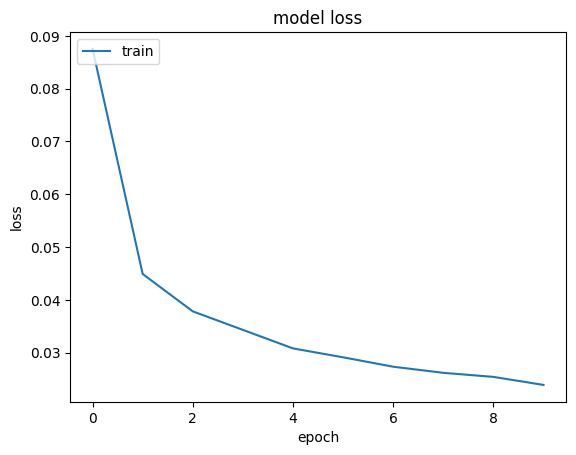

['loss', 'accuracy']
Model Compiled and Trained


In [61]:
## Comment next 2 blocks if loading pre-trained models
## Execute them if training new models

model_gru = GRU_model(82) #quando treina novo modelo
model_cnn = CNN_model(82)
model_lstm = LSTM_model(82)
model_dnn = DNN_model(X_train.shape[1])
model_svm = SVM()
model_lr = LR()
model_gd = GD()
model_knn = kNN()

model_gru.summary()
print(X_train.shape)

model_cnn = compile_train(model_cnn,format_3d(X_train),y_train)

Epoch 1/10
1440/1440 [==============================] - 50s 34ms/step - loss: 0.1818 - accuracy: 0.9434
Epoch 2/10
1440/1440 [==============================] - 50s 34ms/step - loss: 0.0651 - accuracy: 0.9855
Epoch 3/10
1440/1440 [==============================] - 50s 34ms/step - loss: 0.0569 - accuracy: 0.9874
Epoch 4/10
1440/1440 [==============================] - 49s 34ms/step - loss: 0.0548 - accuracy: 0.9874
Epoch 5/10
1440/1440 [==============================] - 55s 38ms/step - loss: 0.0515 - accuracy: 0.9873
Epoch 6/10
1440/1440 [==============================] - 54s 38ms/step - loss: 0.0466 - accuracy: 0.9876
Epoch 7/10
1440/1440 [==============================] - 55s 38ms/step - loss: 0.0407 - accuracy: 0.9884
Epoch 8/10
1440/1440 [==============================] - 57s 40ms/step - loss: 0.0374 - accuracy: 0.9893
Epoch 9/10
1440/1440 [==============================] - 51s 36ms/step - loss: 0.0349 - accuracy: 0.9899
Epoch 10/10
1440/1440 [==============================] - 54s 37m

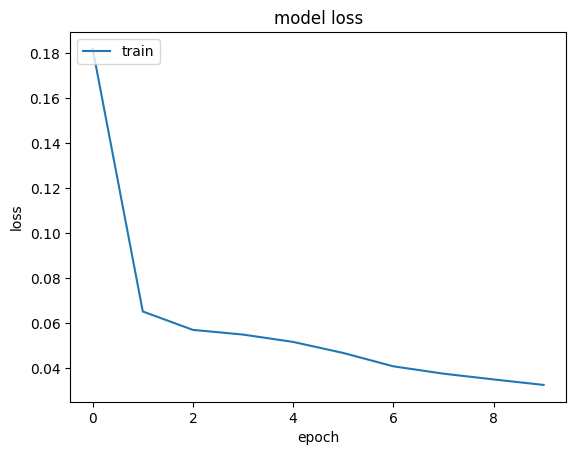

['loss', 'accuracy']
Model Compiled and Trained
Epoch 1/10
1440/1440 [==============================] - 41s 28ms/step - loss: 0.0234 - accuracy: 0.9929
Epoch 2/10
1440/1440 [==============================] - 45s 31ms/step - loss: 0.0224 - accuracy: 0.9933
Epoch 3/10
1440/1440 [==============================] - 37s 26ms/step - loss: 0.0220 - accuracy: 0.9935
Epoch 4/10
1440/1440 [==============================] - 37s 26ms/step - loss: 0.0217 - accuracy: 0.9936
Epoch 5/10
1440/1440 [==============================] - 46s 32ms/step - loss: 0.0212 - accuracy: 0.9938
Epoch 6/10
1440/1440 [==============================] - 39s 27ms/step - loss: 0.0203 - accuracy: 0.9941
Epoch 7/10
1440/1440 [==============================] - 41s 28ms/step - loss: 0.0204 - accuracy: 0.9940
Epoch 8/10
1440/1440 [==============================] - 37s 26ms/step - loss: 0.0192 - accuracy: 0.9945
Epoch 9/10
1440/1440 [==============================] - 38s 26ms/step - loss: 0.0188 - accuracy: 0.9947
Epoch 10/10
1440

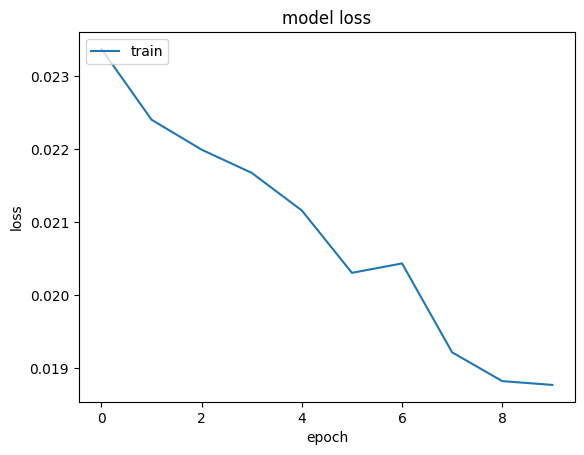

['loss', 'accuracy']
Model Compiled and Trained
Epoch 1/10
1440/1440 [==============================] - 57s 38ms/step - loss: 0.1346 - accuracy: 0.9527
Epoch 2/10
1440/1440 [==============================] - 57s 40ms/step - loss: 0.0496 - accuracy: 0.9874
Epoch 3/10
1440/1440 [==============================] - 54s 38ms/step - loss: 0.0866 - accuracy: 0.9776
Epoch 4/10
1440/1440 [==============================] - 51s 35ms/step - loss: 0.0593 - accuracy: 0.9871
Epoch 5/10
1440/1440 [==============================] - 51s 35ms/step - loss: 0.0532 - accuracy: 0.9881
Epoch 6/10
1440/1440 [==============================] - 51s 35ms/step - loss: 0.0519 - accuracy: 0.9877
Epoch 7/10
1440/1440 [==============================] - 50s 35ms/step - loss: 0.0490 - accuracy: 0.9880
Epoch 8/10
1440/1440 [==============================] - 50s 34ms/step - loss: 0.0457 - accuracy: 0.9883
Epoch 9/10
1440/1440 [==============================] - 50s 34ms/step - loss: 0.0380 - accuracy: 0.9900
Epoch 10/10
1440

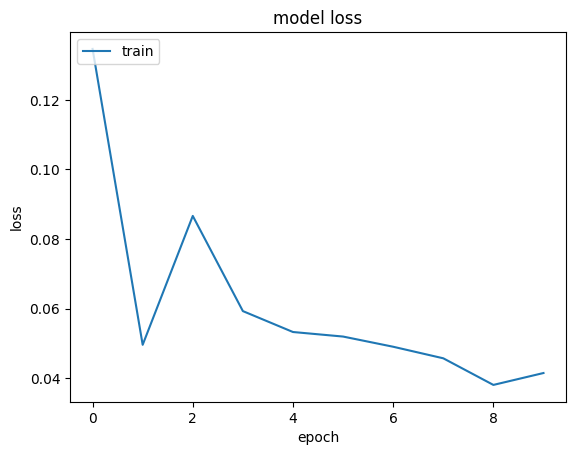

['loss', 'accuracy']
Model Compiled and Trained
Epoch 1/10
1440/1440 [==============================] - 1s 767us/step - loss: 0.1796 - accuracy: 0.9655
Epoch 2/10
1440/1440 [==============================] - 1s 764us/step - loss: 0.0674 - accuracy: 0.9880
Epoch 3/10
1440/1440 [==============================] - 1s 810us/step - loss: 0.0612 - accuracy: 0.9881
Epoch 4/10
1440/1440 [==============================] - 1s 776us/step - loss: 0.0586 - accuracy: 0.9884
Epoch 5/10
1440/1440 [==============================] - 1s 775us/step - loss: 0.0569 - accuracy: 0.9887
Epoch 6/10
1440/1440 [==============================] - 1s 794us/step - loss: 0.0556 - accuracy: 0.9889
Epoch 7/10
1440/1440 [==============================] - 1s 795us/step - loss: 0.0546 - accuracy: 0.9889
Epoch 8/10
1440/1440 [==============================] - 1s 801us/step - loss: 0.0537 - accuracy: 0.9889
Epoch 9/10
1440/1440 [==============================] - 1s 801us/step - loss: 0.0529 - accuracy: 0.9887
Epoch 10/10
1440

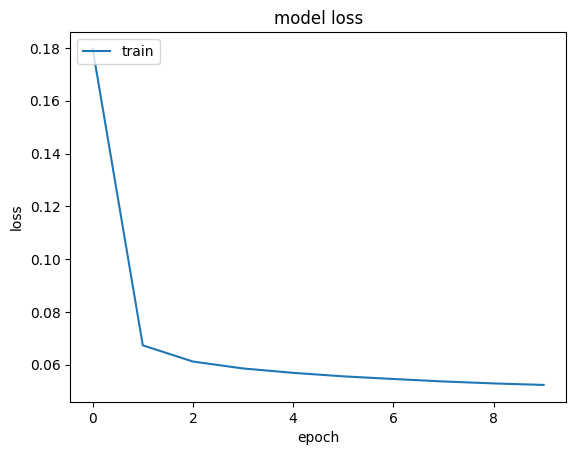

['loss', 'accuracy']
Model Compiled and Trained
Model Compiled and Trained


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Compiled and Trained
Model Compiled and Trained
Model Compiled and Trained


In [62]:
#### For the Next RUN -> divide each model, because the output in jupyter is compressed
## Comment next 2 blocks if loading pre-trained models
## Execute them if training new models

'''model_gru = GRU_model(82) #quando treina novo modelo
model_cnn = CNN_model(82)
model_lstm = LSTM_model(82)
model_dnn = DNN_model(X_train.shape[1])
model_svm = SVM()
model_lr = LR()
model_gd = GD()
model_knn = kNN()

model_gru.summary()'''
 
model_gru = compile_train(model_gru,format_3d(X_train),y_train)  #quando treina novo modelo, ou retreina
model_cnn = compile_train(model_cnn,format_3d(X_train),y_train)
model_lstm = compile_train(model_lstm,format_3d(X_train),y_train)
model_dnn = compile_train(model_dnn,X_train,y_train)
model_svm = compile_train(model_svm,X_train,y_train,False)
model_lr = compile_train(model_lr,X_train,y_train,False)
model_gd = compile_train(model_gd,X_train,y_train,False)
model_knn = compile_train(model_knn,X_train,y_train,False)

## Comment next 2 blocks if training new models
## Execute them if loading pre-trained models

# model_gru = load_model('GRU20-32-b256') #when loading previously saved trained model and weights
# model_cnn = load_model('CNN5-3cam-b2560')
# model_lstm = load_model('LSTM5-32-b256')
# model_dnn = load_model('DNN5-2560')
# model_svm = load_Sklearn('SVM')
# model_lr = load_Sklearn('LR')
# model_gd = load_Sklearn('GD')
# model_knn = load_Sklearn('kNN-1viz')

# model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #qdo carrega modelo salvo
# model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Testing CIC-DDoS2019 

In [63]:
results = pd.DataFrame(columns=['Method','Accuracy','Precision','Recall', 'F1_Score', 'Average','Normal_Detect_Rate','Atk_Detect_Rate'])

### GRU

In [68]:
y_pred = model_gru.predict(format_3d(X_test)) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_gru,format_3d(X_test),y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method': 'GRU',
                          'Accuracy': acc,
                          'Precision': prec,
                          'F1_Score': f1,
                          'Recall': rec,
                          'Average': avrg,
                          'Normal_Detect_Rate': norm,
                          'Atk_Detect_Rate': atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)

9331/9331 [==============================] - 47s 5ms/step - loss: 0.0150 - accuracy: 0.9975
[0.01498925406485796, 0.9974713325500488]

Accuracy
0.9974713475205809

Precision
0.9994161465673445

Recall
0.9975483793179671

F1 Score
0.9984813894783423

Average (acc, prec, rec, f1)
0.9982293157210588


### CNN

In [69]:
y_pred = model_cnn.predict(format_3d(X_test)) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_cnn,format_3d(X_test),y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'CNN', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)

9331/9331 [==============================] - 41s 4ms/step - loss: 0.0180 - accuracy: 0.9927
[0.01795920915901661, 0.9926786422729492]

Accuracy
0.9926786300397216

Precision
0.9921418223469172

Recall
0.9991278660852441

F1 Score
0.9956225895206475

Average (acc, prec, rec, f1)
0.9948927269981326


### LSTM

In [70]:
y_pred = model_lstm.predict(format_3d(X_test))

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_lstm,format_3d(X_test),y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'LSTM', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


9331/9331 [==============================] - 269s 29ms/step - loss: 0.0217 - accuracy: 0.9963
[0.021748574450612068, 0.9962823987007141]

Accuracy
0.9962823784739666

Precision
0.9990410224795613

Recall
0.9964953881397826

F1 Score
0.9977665816223873

Average (acc, prec, rec, f1)
0.9973963426789245


### DNN

In [71]:
y_pred = model_dnn.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_dnn,X_test,y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'DNN', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)

9331/9331 [==============================] - 13s 1ms/step - loss: 0.0619 - accuracy: 0.9979
[0.06188807636499405, 0.9979034066200256]

Accuracy
0.9979033954276605

Precision
0.9982334212607751

Recall
0.9992524566444949

F1 Score
0.9987426790176024

Average (acc, prec, rec, f1)
0.9985329880876332


### SVM

In [72]:
y_pred = model_svm.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_svm,X_test,y_test,y_pred,False)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'SVM', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


Accuracy
0.9986502689414491

Precision
0.9991480332427783

Recall
0.9992323613930029

F1 Score
0.9991901955386405

Average (acc, prec, rec, f1)
0.9990552147789676


### LR

In [73]:
y_pred = model_lr.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_lr,X_test,y_test,y_pred,False)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'LR', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


Accuracy
0.9973005378828983

Precision
0.9990060482167217

Recall
0.9977533508831863

F1 Score
0.9983793066006056

Average (acc, prec, rec, f1)
0.998109810895853


### GB

In [74]:
y_pred = model_gd.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_gd,X_test,y_test,y_pred,False)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'GB', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


Accuracy
0.9986804118186873

Precision
0.9991881844669949

Recall
0.9992283423427044

F1 Score
0.9992082630013666

Average (acc, prec, rec, f1)
0.9990763004074383


### kNN

In [75]:
y_pred = model_knn.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_knn,X_test,y_test,y_pred,False)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'kNN', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


Accuracy
0.9987038562787613

Precision
0.999549571288387

Recall
0.998894761167936

F1 Score
0.9992220589506439

Average (acc, prec, rec, f1)
0.9990925619214321


# Discussion and Results

Showing the table 'results', containing the performance metrics outcomes for each method.

In [76]:
results

,Method,Accuracy,Precision,Recall,F1_Score,Average,Normal_Detect_Rate,Atk_Detect_Rate
0,GRU,0.997471,0.999416,0.997548,0.998481,0.998229,0.997086,0.997548
1,CNN,0.992679,0.992142,0.999128,0.995623,0.994893,0.960432,0.999128
2,LSTM,0.996282,0.999041,0.996495,0.997767,0.997396,0.995217,0.996495
3,DNN,0.997903,0.998233,0.999252,0.998743,0.998533,0.991158,0.999252
4,SVM,0.998650,0.999148,0.999232,0.999190,0.999055,0.995740,0.999232
5,LR,0.997301,0.999006,0.997753,0.998379,0.998110,0.995036,0.997753
6,GB,0.998680,0.999188,0.999228,0.999208,0.999076,0.995941,0.999228
7,kNN,0.998704,0.999550,0.998895,0.999222,0.999093,0.997749,0.998895


**Classification Metrics:**
* Accuracy
* Precision
* Recall
* F1 Measure (F1 Score)

Showing performance outcomes of the methods: 
* GRU
* DNN
* SVM
* LR
* GB
* kNN

LSTM and CNN were separated for visualization improvement.

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

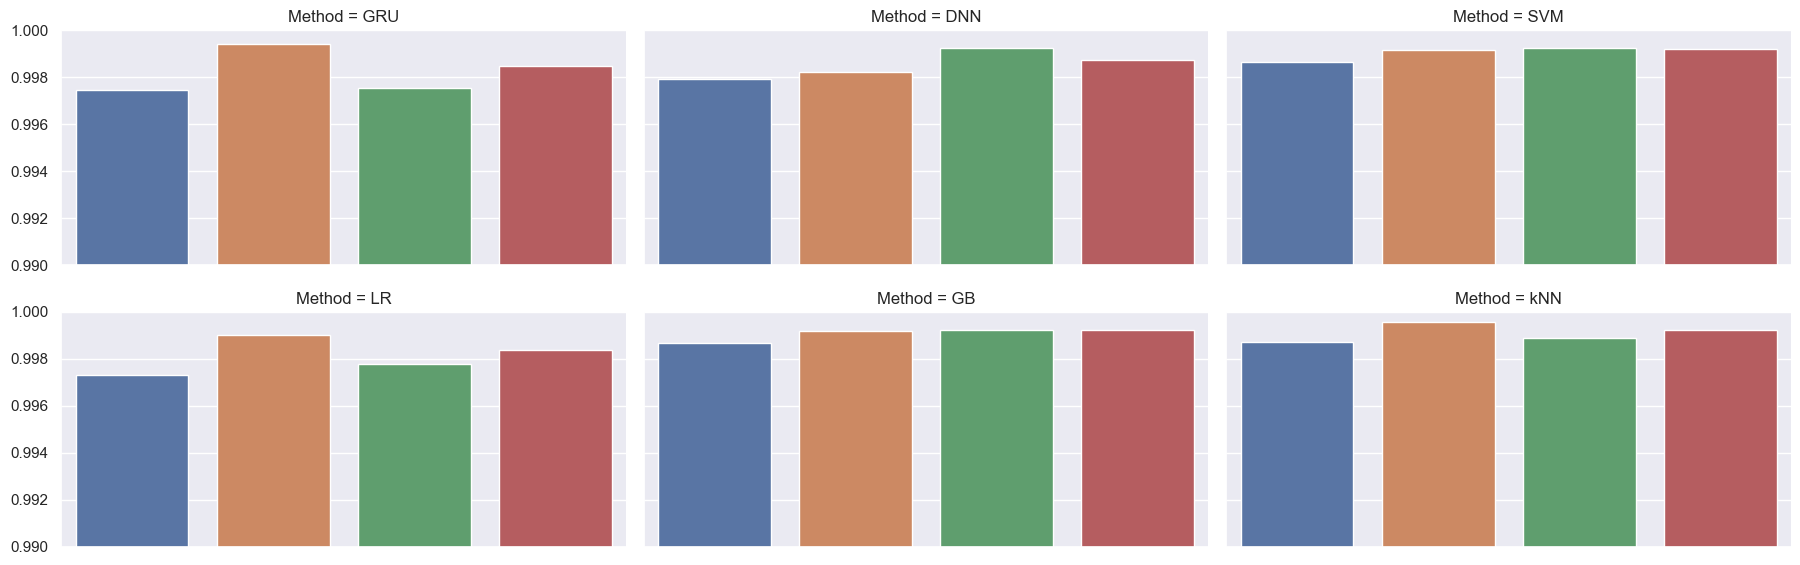

In [78]:
ax = sns.catplot(data=results.iloc[:,:5].query('Method != "LSTM" and Method != "CNN"'), col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.99,1))
ax.set_xticklabels(rotation=45)
ax = ax


> As observed, the evaluated methods achieved good performance outcomes close to 1. As the evaluated methods achieved similar outcomes, a more specific analysis should be performed.

Showing results of the LSTM and CNN methods.

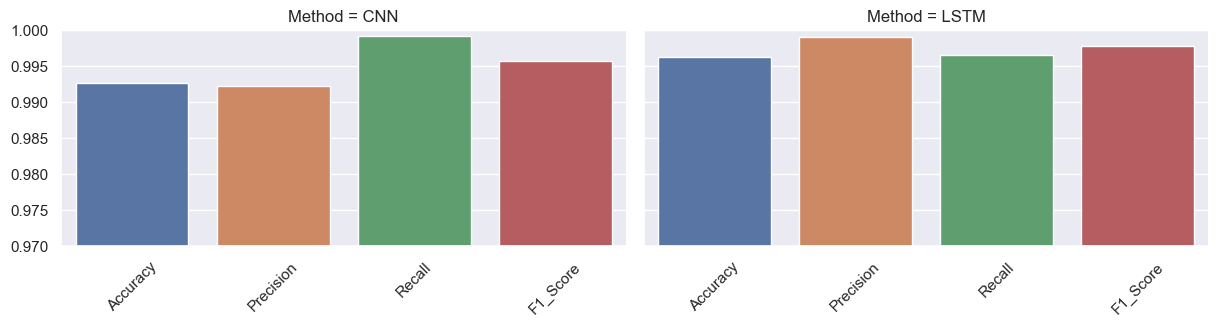

In [79]:
ax = sns.catplot(data=results.iloc[:,:5].query('Method == "LSTM" or Method == "CNN"'), col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.97,1))
ax.set_xticklabels(rotation=45)
ax = ax

> CNN and LSTM fared worse between the tested approaches. However, these methods achieved performance metrics above 97%, which is a relatively good outcome. 

**Average of the Metrics**

Plotting the Average of the previously mentioned performance metrics to summarize the method's results. 

C:\Users\anicc\AppData\Local\Temp\ipykernel_34012\3242924192.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


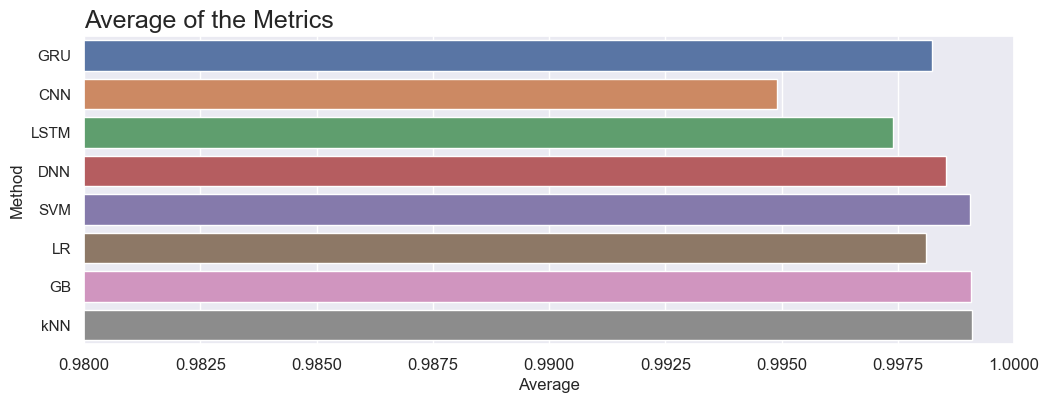

In [81]:
plt.figure(figsize=(12,4))
ax = sns.barplot(data=results, y='Method', x='Average')
ax.set(xlim=(0.98,1))
ax.set_title('Average of the Metrics', fontsize=18, loc='left')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax = ax

> As observed, on average, kNN fared slightly better compared to GB, LR, SVM, and GRU, which, in turn, achieved very similar results. However, these methods performed nearly 99.9%, which is considered a good classification outcome. 

**Detection rate of Normal and Attack flow records**

The following plot shows the results of each method for classifying normal and attack flow records.

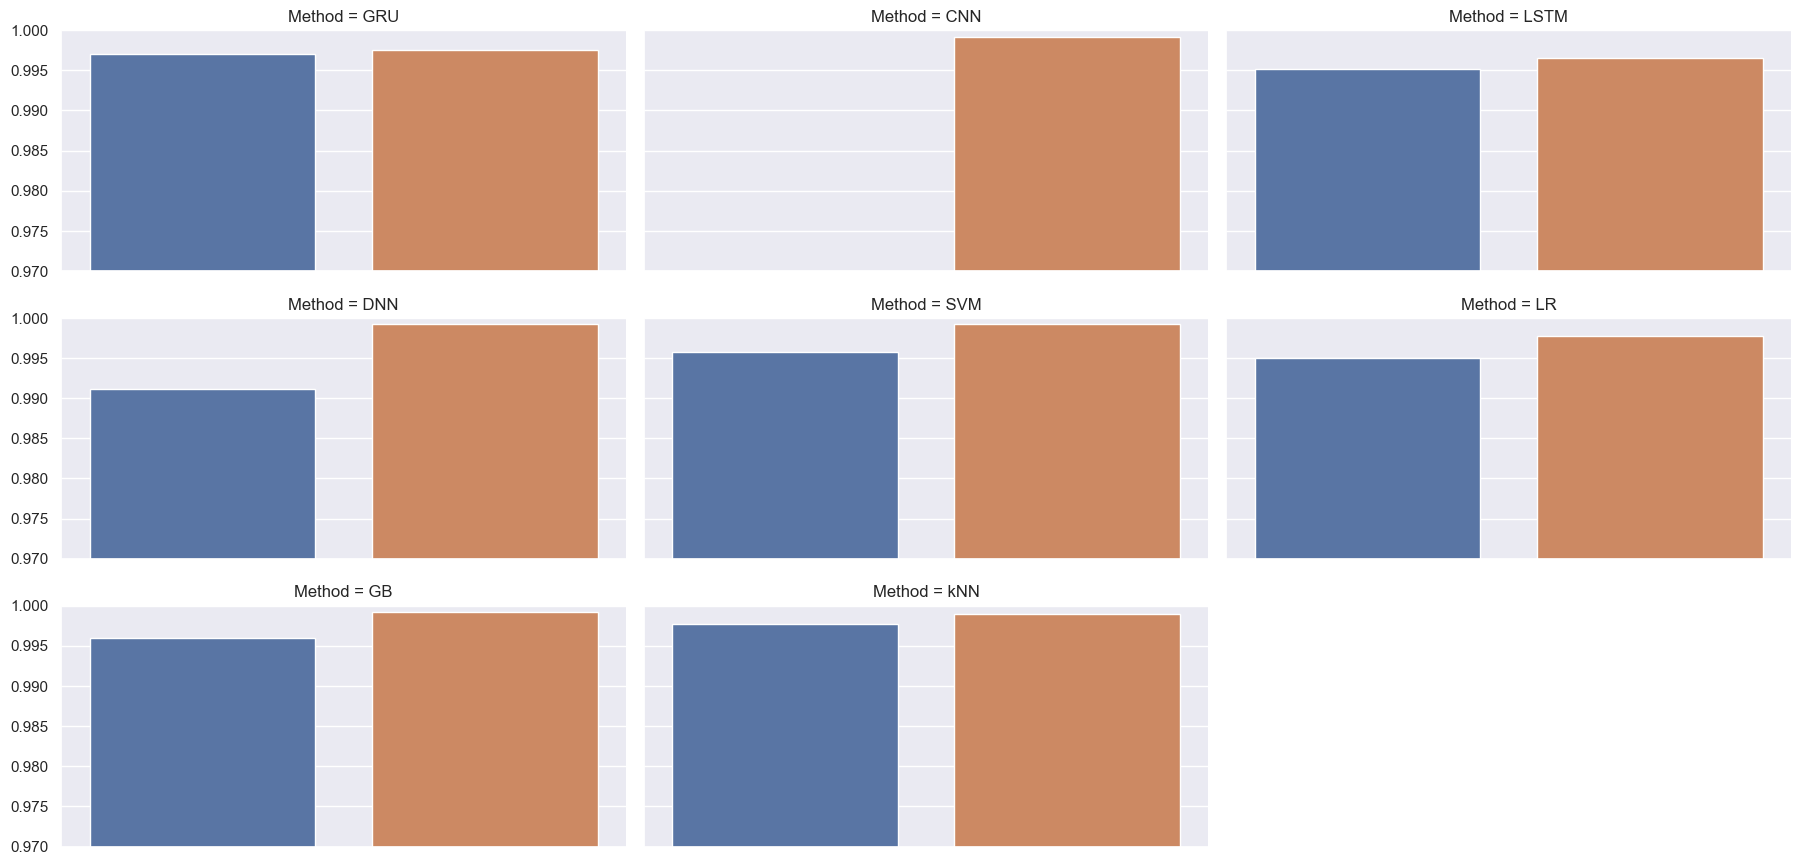

In [82]:
ax = sns.catplot(data=results[['Method', 'Normal_Detect_Rate', 'Atk_Detect_Rate']], col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.97,1))
ax.set_xticklabels(rotation=45)
ax = ax


> kNN achieved the best classification outcomes. 

> GRU showed the most balanced approach regarding classifying normal and attack flows. 

> Although CNN achieved a relatively good classification of attacks, the classification of normal record flows was low compared to other methods. This result can explain the Accuracy rate of this method. This situation also occurs with the LSTM method, which achieved a good classification rate for normal flows and a low classification rate for attack ones. 